# Aproximación Polinomial y aplicaciones

En este notebook se explican tres métodos de aproximación polinomial y se aplican a datos generados de manera aleatoria y a datos experimentales de la concentración en sangre de un metal.

Los tres métodos que se expondrán, son: Interpolación polinomial con matriz de Vandermonde, aproximación por medio de splines cúbicos y ajuste polinomial por medio de la reducción del error cuadrático.

Así mismo, se integrará numéricamente las funciones obtenidas, para mostrar las ventajas asociadas a la aproximación polinomial.

Primero, se construirá una función que permita interpolar un conjunto de puntos dados por medio de la matriz de Vandermonde.

## Método de Vandermonde

Dato un conjunto de puntos

$$
\{ (x_i, y_i) : 0 \leq i \leq n\}
$$

Es posible interpolar un polinomio de grado $\leq n$, que cumpla que

$$
P_n(x_i) = y_i
$$

para toda $i$.

Así, como el grado de $P_n$ es $n$, podemos escribir que

$$
P_n(x) = \sum_{k=0}^n c_k x^k
$$

Y si exigimos que $P_n$ pase por los puntos, se tiene que

$$
c_0 + x_i c_1 + x_i^2 c_2 + ... + c_n x_i^n = y_i
$$

como esto debe cumplirse para cada $i$, las $n$ ecuaciones determinan un sistema de ecuaciones con $n$ ecuaciones e incógnitas. Si se define la matriz $V$ de Vandermonde como

$$
V = 
\begin{pmatrix}
1 & x_0 & x_0^2 & ... & x_0^n\\
1 & x_1 & x_1^2 & ... & x_1^n\\
\vdots & \vdots & \vdots & \ddots & \vdots\\
1 & x_n & x_n^2 & ... & x_n^n
\end{pmatrix}
$$

Podemos reexpresar nuestro sistema de ecuaciones como

$$
V \mathbf{c} = \mathbf{y}
$$

donde $\mathbf{c} = (c_0, c_1, ..., c_n)^T$ es el vector de coeficientes y $\mathbf{y}$ es el vector de coordenadas $y$ de los puntos.

De acuerdo a lo visto en clase, la unicidad de los polinomios, nos asegura que este sistema tiene solución única en caso de tenerla, por lo que utilizando algún método de solución de ecuaciones lineales, es posible obtener al vector $\mathbf{c}$ de coeficientes y con esto construir a nuestro polinomio.

## Splines Cúbicos

La principal desventaja del método de Vandermonde, radica en el hecho de que el grado del polinomio queda determinado por el número de puntos, lo que impide en muchos casos extrapolar, además de que para puntos distintos de los puntos de interpolación, el comportamiento real de la función es imposible de conocer, ya que es posible que los puntos provengan de una función de un grado menor o mayor al fijado por este método.

Una forma de subsanar esta desventaja, es por medio del método de Splines Cúbicos, el cuál ajusta un polinomio de grado 3 a nuestros puntos. Existen dos formas de realizar esto, aunque en ambos casos, el polinomio generado, será un polinomio de grado 3 a cachos, es decir, su regla de correspondencia será distinta para distintos intervaloes.

### Splines Cúbicos por Vandemonde

El primer método consiste en utilizar la interpolación por el método de vandermonde y tomar grupos de 4 puntos para obtener un polinomio de grado 3.

El método consiste en que dado el conjunto de puntos

$$
\{ (x_i, y_i) : 0 \leq i \leq n\}
$$

obtener el residuo de la división $(n+1)/4$, y de acuerdo al residuo, tomar solamente 
$[(n+1) - $ residuo $]$ de puntos. Se recomienda tomar en cada caso, los puntos del medio, ya que de esta manera, no se tiene al inicio o final, ningún intervalo grande donde el polinomio no se aproxime a la función.

El polinomio obtenido mediante este método, requiere la solución de $[(n+1)-$ residuo $]/4$ sistemas de ecuaciones de 4 incógnitas. Este polinomio será continuo y diferenciable en todos los puntos, excepto en los cambios de polinomio, ya que nada asegura la continuidad de la derivada de la función en estos puntos. Es por esto que el segundo método es preferible a este, ya que el otro método nos asegura la diferenciabilidad del polinomio obtenido y aunque el número de incógnitas es mayor, se soluciona únicamente un sistema de ecuaciones.



## Código para la interpolación de Vandermonde

In [1]:
## Importamos las librerías a utilizar.

import numpy as np
from numpy import linalg as la
import matplotlib.pyplot as plt
import csv

Primero crearemos una función que obtenga la matriz de Vandermonde, dada la coordenada $x$ de los datos. Como después podremos elegir el grado del polinomio, uno de los argumentos de la función también será el grado del polinomio a aproximar

In [2]:
def VandMatr(datosX,grado):
    m = len(datosX)
    grado = grado+1
    V = np.zeros((m,grado))
    
    #LLenado de Matriz
    for i in range(m):
        for j in range(grado):
            V[i][j] = datosX[i]**j
    
    return V

Ahora, creamos nuesta función que obtenga los coeficientes del polinomio que interpola a los datos.

In [3]:
# La función toma como argumento a un array que contenga a los datos [x_i,y_i] como entradas
# siendo la primer columna los datos x y la segunda los datos y

def CoefVand(datos):
    
    datos = np.array(datos)
    
    V = VandMatr(datos[:,0],len(datos)-1)
    
    c = la.solve(V,datos[:,1])
    
    return c

Utilizando nuestra función de coeficientes, crearemos una función que arroje el polinomio aproximado. Se requiere que una de las entradas sea la variable del polinomio para que se pueda extrapolar a una función de una sola variable lo que esta función regrese

In [4]:
# La primer enta¡rada contiene a los datos interpolar
# La segunda entrada contiene la variable del polinomio

def InterpVand(datos,x):
    
    c = CoefVand(datos)
    
    polin = 0
    
    for i in range(len(c)):
        polin += c[i]*(x**i)
    
    return polin


### Splines Cúbicos con continuidad de la derivada

Dados datos de la forma $(x_i, y_i)$ con $1 \leq i \leq n+1$, se interpolará un polinomio de grado 3 a cachos que tenga primer y segunda derivada continua.

Para asegurar la continuidad de las derivadas, es necesario establecer que el polinomio obtenido a cachos coincida en todos los puntos a interpolar y sus derivadas también lo hagan.

El hecho de imponer nuevas restricciones, nos provee de más ecuaciones, por lo que en lugar de aproximar un polinomio de grado 3 en 4 puntos de nuestros datos, obtendremos un polinomio de grado 3 en cada subintervalo de la forma $[x_i, x_{i+1}]$ donde $1 \leq i \leq n$.
Esto quiere decir que si tenemos $(n+1)$ puntos a interpolar, tenemos $n$ subintervalos de la forma descrita arriba y por ende, $n$ polinomios de grado 3.

Al tener $n$ polinomios de grado $3$, tenemos $4n$ incógnitas, ya que las incógnitas son los coeficientes de nuestros polinomios.

Sea $P_i$ el $i$-ésimo polinomio. El polinomio $P_i$ está definido en el intervalo 
$[x_i, x_{i+1}]$ y tiene como regla de correspondencia

$$
P_i(x) = a_i + b_i x + c_i x^2 + d_i x^3
$$

Nuestras incógnitas con $a_i, b_i, c_i, d_i$ para cada $i$. 

Utilizando las condiciones establecidas, se debe cumplir que

$$
P_i(x_i) = a_i + b_i x_i + c_i x_i^2 + d_i x_i^3 = y_i
$$

$$
P_i(x_{i+1}) = a_i + b_i x_{i+1} + c_i x_{i+1}^2 + d_i x_{i+1}^3 = y_{i+1}
$$

Es decir, nuestro polinomio debe pasar por los puntos $(x_i,y_i)$ y $(x_{i+1}, y_{i+1})$  estableciendo la continuidad del polinomio a cachos.

Como tenemos $n$ polinomios y cada uno tiene dos de estas condiciones, se tienen $2n$ ecuaciones.

Para la continuidad de la derivada, no podemos establecer una igualdad a algún número, ya que no conocemos el valor de la derivada, por lo que haremos uso de la igualdad entre polinomios. La condición para los puntos interiores es

$$
P_i'(x_{i+1}) = P_{i+1}'(x_{i+1})
$$

Que en términos de nuestras reglas de correspondencia es

$$
b_i+ 2 c_i x_{i+1} + 3 d_i x_{i+1}^2 = b_{i+1} + 2 c_{i+1} x_{i+1} + 3 d_{i+1} x_{i+1}^2
$$

Reescribiendo esto, se tiene que

$$
b_i+ 2 c_i x_{i+1} + 3 d_i x_{i+1}^2 - b_{i+1} - 2 c_{i+1} x_{i+1} - 3 d_{i+1} x_{i+1}^2 =0
$$



Como se tienen $n-1$ puntos interiores, se tienen $(n-1)$ ecuaciones para esta condición.

La misma condición se establece para la segunda derivada, haciedo nuestro polinomio suave. Teniendo que

$$
P_i''(x_{i+1}) = P_{i+1}(x_{i+1})
$$

que en términos de nuestras reglas de correspondecia se tiene que

$$
2 c_i + 6 d_i x_{i+1} = 2 c_{i+1} + 6 d_{i+1} x_{i+1}
$$

reescribiendo, se tiene que

$$
2 c_i + 6 d_i x_{i+1} - 2 c_{i+1} - 6 d_{i+1} x_{i+1} = 0
$$

Y como existen $(n-1)$ puntos interiores, se obtiene otras $(n-1)$ ecuaciones.

En total, existen $(4n-2)$ ecuaciones, haciendo falta $2$ ecuaciones más. Para afectar lo menos posible el resultado, se establece que la segunda derivada del primer y último polinomio evaluados en el primer y último dato sea cero, teniendo que

$$
P_1''(x_1) = 2 c_1 + 6 d_1 x_1 = 0 
$$

$$
P_n'' (x_{n+1}) = 2 c_n + 6 d_n x_{n+1} = 0
$$

Añadiendo estas dos últimas ecuaciones, se tiene las $4n$ ecuaciones necesarias para obtener los coeficientes de nuestros polinomios.

### Algoritmo

El algoritmo en este caso consiste en la definición de nuestra matriz de valores evaluados, que denotaremos como $X$, la definición de nuestro vector $\mathbf{b}$ que contendrá los valores a lo que se igualan las ecuaciones, y la solución de la ecuación

$$
X \mathbf{c} = \mathbf{b}
$$

donde $\mathbf{c}$ es el vector que contendrá los ecoeficientes de nuestros polinomios. Para un manejo sencillo, se ordena $\mathbf{c}$ como

$$
\mathbf{c} = (a_1, b_1, c_1, d_1, ..., a_n, b_n, c_n, d_n)^T
$$

Por lo que por facilidad, las ecuaciones se pueden escribir en el orden de los polinomios y no en el orden de las derivadas. 

Es importante notar que el primer y último polinomio tendrán un tratamiento especial, debido a la condición de la segunda derivada igualada a cero en los extremos, sin embargo, para todos los polinomios $P_i$ para $1 \leq i \leq n-1$ se cumple que 

$$
a_i + b_i x_i + c_i x_i^2 + d_i x_i^3 = y_i
$$

$$
a_i + b_i x_{i+1} + c_i x_{i+1}^2 + d_i x_{i+1}^3 = y_{i+1}
$$

$$
b_i+ 2 c_i x_{i+1} + 3 d_i x_{i+1}^2 - b_{i+1} - 2 c_{i+1} x_{i+1} - 3 d_{i+1} x_{i+1}^2 =0
$$

$$
2 c_i + 6 d_i x_{i+1} - 2 c_{i+1} - 6 d_{i+1} x_{i+1} = 0
$$

Para el caso del último polinomio, solamente son válidas las primeras dos ecuaciones, así, se pueden llenar en ciclo los renglones correspondientes a las primeras dos ecuaciones para todos los polinomios y en el caso de las últimas dos ecuaciones, solamente se llenará si el índice no corresponde al último polinomio.

La matriz $X$ será una matriz cuadrada de dimensión $4n \times 4n$. Y para cada segemnto correspondiente un polinomio, tendrá la forma

$$
\begin{pmatrix}
... & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & ...\\
... & 1 & x_i & x_i^2 & x_i^3 & 0 & 0 & 0 & 0 & ...  \\
... & 1 & x_{i+1} & x_{i+1}^2 & x_{i+1}^3 & 0 & 0 & 0 & 0 & ...\\
... & 0 & 1 & 2 x_{i+1} & 3 x_{i+1}^2 & 0 & -1 & -2x_{i+1} & -3 x_{i+1}^2 & ...\\
... & 0 & 0 & 2 & 6 x_{i+1} & 0 & 0 & -2 & -6 x_{i+1} & ...\\
... & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & ...
\end{pmatrix}
$$

Los índices de los renglones en Python son $4i$, $(4i+1)$, $(4i+2)$, $(4i+3)$, los índices de las columnas van desde el $4i$ hasta el $[4(i+1)+3]$. Ya que abarcan los coeficientes del polinomio $i$ y el polinomio $(i+1)$.

## Código de Splines Cúbicos

Lo primero a tener en cuenta, es que para este código, se requiere que los datos estén ordenados por su coordenada $x$, lo cuál no siempre se tiene en los datos crudos, por lo que se crearán funciones para ordenar los datos por su coordenada $x$.

In [5]:
def permut_row(A,ind1,ind2):
    B = np.copy(A)
    A[ind1] = B[ind2]
    A[ind2] = B[ind1]
    return A

def OrdDatos(datos):
    
    # Cantidad de datos
    m = len(datos)
    
    for i in range(m):
        # vector auxiliar
        aux = []
        
        # Datos posteriores a i
        for j in range(i,m):
            aux.append(datos[j][0])
        
        ind = aux.index(min(aux)) + i
        
        if ind != i:
            datos = permut_row(datos,ind,i)
    
    return datos

Definiremos ahora la función que obtiene la matriz $X$ y el vector $\mathbf{b}$ a partir de los datos ya ordenados.

In [6]:
def MatSplCub(datos):
    
    # Cantidad de puntos
    n = len(datos)
    
    # Coordenada x de los datos
    xdatos = datos[:,0]
    
    # Coordenada y de los datos
    ydatos = datos[:,1]
    
    # Número de polinomios
    n = n-1
    
    # Matriz X
    X = np.zeros((4*n,4*n))
    
    # Vector b
    b = np.zeros(4*n)
    
    # Llenado de los renglones correspondientes
    # a las primeras dos ecuacines
    for i in range(n):
        # Valor auxiliar para renglones
        k = 4*i
        
        # Primer y segunda ecuación
        # Llenado de Matriz
        for j in range(4):
            X[k][k+j] = xdatos[i]**j
            X[k+1][k+j] = xdatos[i+1]**j
        # Llenado del vector
        b[k] = ydatos[i]
        b[k+1] = ydatos[i+1]
        
        # Condición para los primeros n-1 polinomios
        if i != n-1:
            # Llenado de los renglones correspondientes a la
            # tercer ecuación
            for j in range(1,4):
                X[k+2][k+j] = j*(xdatos[i+1]**(j-1))
                X[k+2][k+4+j] = (-j)*(xdatos[i+1]**(j-1))
            
            # Llenado de los renglones correspondientes a la
            # cuarta ecuación
            for j in range(2,4):
                X[k+3][k+j] = np.math.factorial(j)*(xdatos[i+1]**(j-2))
                X[k+3][k+4+j] = (-1)*np.math.factorial(j)*(xdatos[i+1]**(j-2))
            
            
    
    # Llenado de las dos ecuaciones adicionales
    k = 4*(n-1)
    for j in range(2,4):
        X[k+2][j] = np.math.factorial(j)*(xdatos[0]**(j-2))
        X[k+3][k+j] = np.math.factorial(j)*(xdatos[n]**(j-2))
    
    
    
    return X,b

Ahora se creará la función que obtendrá los coeficientes de los $n$ polinomios.

In [7]:
def CoefSplCub(datos):
    #Ordenado de datos
    datos = OrdDatos(datos)
    
    # Matriz y vector construidos
    X,b = MatSplCub(datos)
    
    # Obtención de coeficientes
    c = la.solve(X,b)
    
    # Regresa los datos ya ordenados
    return c,datos

Se definirá la función que permitirá obtener el polinomio a cachos a partir de una variable que quedará libre, y que determinará que coeficientes utilizar a partir del valor que $x$ tenga.

In [8]:
def SplCub(datos,x):
    # Numpy array datos
    datos = np.array(datos)
    
    # Obtiene los coeficientes y los datos ya ordenados.
    c,datos = CoefSplCub(datos)
    
    # Número de datos
    n = len(datos)
    # Número de polinomios
    n = n-1
    
    # Ubiación de x
    indice=0
    for i in range(1,n):
        if x>datos[i][0]:
            indice = indice+1
    
    # Ubicación de los coeficientes
    k = 4*indice
    
    # Polinomio a regresar
    pol = 0
    for i in range(4):
        pol = pol + c[k+i]*(x**i)
    
    return pol

## Ajuste polinomial

El ajuste polinomial, consiste en un tipo de aproximación polinomial en el cuál el grado del polinomio se fija, y se encuentra el polinomio que mejor se aproxima a los datos.

La mejor aproximación se refiere a aquel polinomio $P_n(x)$ que minimiza la suma del error cuadrático en cada punto de evaluación. Es decir, es qué polinomio que minimiza la expresión

$$
Err = \sum_{k=1}^m(P_n(x_k) - y_k)^2
$$



Si expremos al polinomio en términos de la matriz de Vandermonde, es posible reducir esta expresión a algo más sencillo.

Considerando que en este caso se tienen $m$ datos y se desea un polinomio de grado $n$, la matriz de Vandermonde tendrá dimensiones de $m \times (n+1)$. 

$$
V = 
\begin{pmatrix}
1 & x_0 & x_0^2 & ... & x_0^n\\
1 & x_1 & x_1^2 & ... & x_1^n\\
\vdots & \vdots & \vdots & \ddots & \vdots\\
1 & x_m & x_m^2 & ... & x_m^n
\end{pmatrix}
$$

Así, el error cuadrático corresponde a 

$$
Err = ||V\mathbf{c} - \mathbf{y}||^2
$$

Y de acuerdo a lo visto en la primer parte del curso, el vector $\mathbf{c}$ que minimiza esta expresión, es solución a la ecuación

$$
V^T V \mathbf{c} = V^T \mathbf{y}
$$

Por lo que los coeficientes de la aproximación polinomial, se obtienen mediante la solución al sistema de ecuaciones normales.

## Código para Ajuste Polinomial

Crearemos una función que obtenga directamente el polinomio ajustado, los argumentos de la función serán los datos, el grado deseado y la variable del polinomio

In [9]:
def AjusPoli(datos,grado,x):
    datos = np.array(datos)
    
    #Matriz de Vandermonde
    V = VandMatr(datos[:,0],grado)
    
    # Obtención de coeficientes
    c = la.solve(V.T@V, V.T@datos[:,1])
    
    # Creación de polinomio
    polin = 0
    for i in range(grado+1):
        polin += c[i]*(x**i)
    return polin

## Comparación de los métodos para una función conocida.

Se aproximará una función por medio de los tres métodos, y se graficaran las aproximaciones y la función original. Se compararán las gráficas y se graficarán los puntos de interpolación.

### Generación de datos por medio de una función

Utilizaremos la función 

$$
f(x) = e^{-x^2}
$$

Y dado un conjunto de puntos aleatorios entre el [-5,5], nuestros puntos de interpolación serán (x,f(x)).

In [10]:
# Función a aproxmimar
def f(x):
    return np.exp(-x**2)
    #return x**3 -2*x**2 + 5
    #return np.exp(x)
    #return np.cos(x)

In [11]:
# Creación de datos
X = np.random.uniform(-2.5,2.5,size=30)
Y = f(X)
data = np.vstack((X,Y))
data = data.T

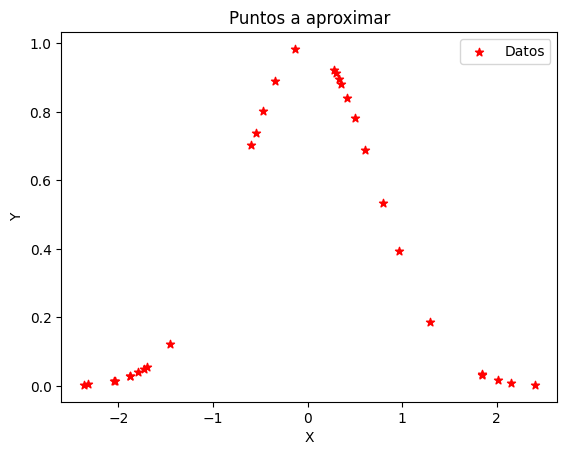

In [12]:
# Observación de los puntos a interpolar

plt.scatter(X,Y, c='r', marker = '*', label="Datos")

plt.xlabel("X")
plt.ylabel("Y")
plt.title("Puntos a aproximar")

plt.legend()

plt.show()

In [13]:
# Obtención de aproximaciones

def P1(x):
    return InterpVand(data,x)

def P2(x):
    return SplCub(data,x)

def P3(x):
    return AjusPoli(data,3,x)

In [14]:
dataOrd = OrdDatos(data)

xmin = dataOrd[0][0]
xmax = dataOrd[len(dataOrd)-1][0]

In [15]:
Dom = np.linspace(xmin-0.32,xmax+0.32,100)

Y0 = f(Dom)

Y1 = P1(Dom)

Y2 = np.zeros(100)
for i in range(100):
    Y2[i] = P2(Dom[i])

Y3 = P3(Dom)

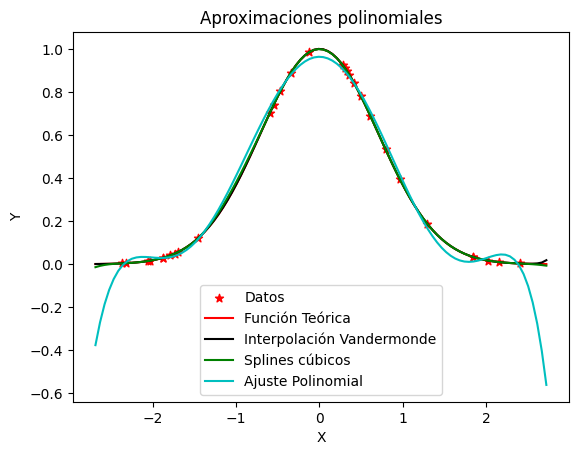

In [16]:
# Gráfica de aproximaciones

plt.scatter(X,Y, c='r', marker = '*', label="Datos")
plt.plot(Dom,Y0, c='r', label="Función Teórica")
plt.plot(Dom,Y1, c='k', label="Interpolación Vandermonde")
plt.plot(Dom,Y2, c='g', label="Splines cúbicos")
plt.plot(Dom,Y3, c='c', label="Ajuste Polinomial")

plt.xlabel("X")
plt.ylabel("Y")
plt.title("Aproximaciones polinomiales")


plt.legend()

plt.show()

# Integración Numérica por medio de polinomios

Las ventajas del ajuste polinomial en comparación con la interpolación, tienen como base el hecho de que los datos experimentales, muchas veces difieren de la función descrita debido a errores en la medición. Por lo que el ajuste polinomial permite aproximar un polinomios del grado deseado, de acuerdo a la tendencia de los datos, y no a los datos en sí. Sin embargo, las interpolaciones polinomiales tienen la ventaja de que estas pueden servir para el cálculo de integrales de las funciones.

## Integral Numérica

La integral de una función real, es una operación cuyos fundamentos se basan en el manejo del concepto de infinito, ya que la integral (de Riemann) está definida como la suma infinita de áreas debajo de la curva.

Teóricamente, las sumas se pueden manejar de tal forma que estas desaparecen, y la integral de una función (en la mayor parte de los casos), consiste en encontrar (en caso de existir) la función primitiva de la función a integrar para obtener el valor numérico deseado.

Sin embargo, computacionalmente es más sencillo obtener el valor numérico, por medio de cálculos que manualmente podrían resultar imposibles. 

Los algoritmos para obtener el valor numérico, se basan en la definición de integral, y en la linealidad de la misma. 


## Integral numérica del trapecio

El algoritmo más simple de integración numérica, es el que está basado en la definición de integral de Riemann. 

Sea una función $f:[a,b] \subset \mathbb{R} \longrightarrow \mathbb{R}$. Podemos aproximar la integral de $f$ en el intervalo $[a,b]$ dividiendo al intervalo en $n$ partes iguales, y después obteniendo un área aproximada al área debajo de la curva de la función.

Denotaremos a cada extremos de los subintervalos como $t_i$ para $0 \leq i \leq n$, por lo que cada intervalo $[t_i, t_{i+1}]$ tendrá una longitud dada por $(t_{i+1} - t_i)$. Como los intervalos tienen la misma longitud, se cumple que

$$
t_{i+1} - t_i = \frac{b-a}{n}
$$

Por otro lado, una forma sencilla de aproximar a la función en el intervalo $[t_i, t_{i+1}]$, es mediante una recta que pase por los puntos $(t_i, f(t_i))$ y $(t_{i+1}, f(t_{i+1}))$. Esto definirá un trapecio en cada subintervalo, por lo que obteniendo el área del trapecio en cada subintervalo, y sumando las áreas, se obtendrá una aproximación de la integral.

$$
\int_a^b f \approx \sum_{i=1}^n A_i
$$

Donde $A_i$ con $(1 \leq i \leq n)$ es el área de cada trapecio dada por

$$
A_i = \left( \frac{f(t_{i-1}) + f(t_i)}{2} \right) \left( \frac{b-a}{n} \right)
$$

En general, el número de particiones $n$ no suele tomarse muy grande, ya que la teoría está construida para un cálculo manual, sin embargo, entre mayor sea $n$, mejor será la aproximación numérica.

## Integración Numérica por Simpson

Una forma de mejorar la aproximación de la integral, es mejorando la aproximación a la función a integrar. La integral numérica del método anterior, puede verse como la suma de las integrales de polinomios de grado uno en cada subintervalo dado. De hecho, podemos ver que la recta en el intervalo $[t_i, t_{i+1}]$, está dada por la ecuación

$$
P(x) = mx + b
$$

Donde $m$ es la pendiente de la recta, y $b$ es la ordenada al origen. Podemos obtener $m$ explícitamente

$$
m = \frac{f(t_{i+1}) - f(t_i)}{t_{i+1} - t_i} = \frac{f(t_{i+1}) - f(t_i)}{b-a} n
$$

Y exigiendo que se cumple la ecuación para un punto, obtenemos que

$$
P(x) = \frac{f(t_{i+1}) - f(t_i)}{b-a} n (x - t_i) + f(t_i)
$$

Reescribiendo esto, se obtiene que

$$
P_i(x) = \frac{f(t_{i+1}) - f(t_i)}{b-a} n x - \frac{f(t_{i+1}) - f(t_i)}{b-a} n t_i + f(t_i)
$$

Siendo el área aproximada $A_i$ la integral de el polinomio.

$$
A_i = \int_{t_i}^{t_{i+1}} P_i(x) = \frac{f(t_{i+1}) - f(t_i)}{b-a} \frac{n}{2} 
(t_{i+1}^2 - t_i^2) + \left( f(t_i) - \frac{f(t_{i+1}) - f(t_i)}{b-a} n t_i \right) (t_{i+1} - t_i)
$$

Usando que $(t_{i+1}^2 - t_i)^2 = (t_{i+1} - t_i)(t_{i+1} + t_i)$, podemos reescribir todo como

$$
A_i = \frac{f(t_{i+1}) - f(t_i)}{b-a} \frac{n}{2}(t_{i+1} - t_i) \left( \frac{t_{i+1} + t_i}{2} - t_i \right) + f(t_i)(t_{i+1} - t_i)
$$

Reduciendo, se obtiene que

$$
A_i = \frac{f(t_{i+1}) - f(t_i)}{b-a} \frac{n}{2} (t_{i+1} - t_i) \left( \frac{t_{i+1} - t_i}{2}\right) + f(t_i)(t_{i+1} - t_i)
$$

Y utilizando el hecho de que $(t_{i+1} - t_i) = (b-a)/n$, se obtiene que

$$
A_i = \frac{f(t_{i+1}) - f(t_i)}{b-a} \frac{n}{2} \left(\frac{b-a}{n}\right)^2 + f(t_i)\frac{b-a}{n} = \frac{f(t_{i+1}) - f(t_i)}{2} \left(\frac{b-a}{n}\right) + f(t_i)\frac{b-a}{n}
$$

Y sumando, obtenemos lo que anteriormente se había obtenido

$$
A_i = \frac{f(t_{i+1}) + f(t_i)}{2} \left(\frac{b-a}{n}\right)
$$

De acuerdo a lo que vimos anteriormente, el hecho de que la función se haya aproximado con un polinomio de grado uno, implica un error de Orden cuadrático en la función.

Así, en lugar de aumentar la $n$, simplemente se puede aproximar un polinomio de mayor grado a la función $f$, y aproximar la integral de $f$ por medio de la integral de $P(x)$. Usualmente, se utiliza un polinomio de grado tres, ya que este es relativamebte versátil. En esto consiste la integración por método de Simpson.

### Algoritmo

Dada una función $f:[a,b] \subset \mathbb{R} \longrightarrow \mathbb{R}$ y dado $P(x)$ polinomio de grado tres que interpola a $f$ en $[a,b]$. La integral de $f$ en el intervalo $[a,b]$, se puede aproximar mediante

$$
\int_a^b f \approx  \int_a^b P
$$

Como vimos anteriormente, para poder aproximar a $f$ mediante un polinomio $P$ de grado tres, es necesario tener 4 puntos de $f$ en el intervalo $[a,b]$. Los puntos que suelen tomarse son $(a,f(a)),$ $((b-a)/3, f[(b-a)/3]),$ $(2(b-a)/3, f[2(b-a)/3]),$ y $(b, f(b))$.

Por medio del método de Vandermonde, es posible obtener los coeficientes del polinomio que interpola a $f$ en $[a,b]$, obteniendo que la integral de $f$ en $[a,b]$, puede aproximarse como

$$
\int_a^b f \approx c_0(b-a) + c_1\frac{b^2 - a^2}{2} + c_2 \frac{b^3 - a^3}{3} 
+ c_3\frac{b^4-a^4}{4}
$$

## Código para integración por método de Simpson

Comenzaremos con la creación de funciones auxiliares. La primer función auxiliar, nos permitirá obtener los cuatro puntos necesarios para interpolar a $f$, dados los límites de integración, y la función.

In [17]:
def PuntInt(func,a,b):
    xdatos = np.linspace(a,b,4)
    ydatos = np.zeros(4)
    for i in range(4):
        ydatos[i] = func(xdatos[i])
    datos = np.vstack((xdatos,ydatos))
    datos = datos.T
    return datos

Definiremos ahora la función que obtendrá la integral numérica de $f$, dada $f$, y los límites $a,b$. Utilizaremos nuestra función auxiliar, y la función auxiliar para el método de Vandermonde, que obtiene los coeficientes de la interpolación.

In [18]:
def IntSimp(func,a,b):
    datos = PuntInt(func,a,b)
    c = CoefVand(datos)
    integ = 0
    for i in range(4):
        integ += (c[i]*(b**(i+1)-a**(i+1)))/(i+1)
    return integ

## Integración Método de Simpson Compuesto

El método de Simpson compuesto, consiste en la partición del intervalo $[a,b]$ en $n$ subintervalos, y en la implementación del método de simpson en cada uno de estos subintervalos. 

Notamos que esto es algo similar al problema de los Splines Cúbicos, sin embargo, la integración numérica es aún más sencilla, ya que al conocer la función a integrar $f$, es posible obtener los cuatro puntos necesarios, en cada subintervalo, por lo que la función que obtenga la integral mediante este algoritmo, únicamente tendrá que dividir el intervalo en $n$ partes.

### Código para la integración por el método de Simpson Compuesto

Utilizaremos nuestra función anterior, y directamente obtendremos la función que integra mediante este método, los argumentos que tendrá esta función, serán: la función a integrar $f$, los limites de integración $a,b$ y el número de particiones deseadas $n$. En el caso de que $n=1$, se obtiene la inetegración de Simpson usual.

In [19]:
def IntSimpComp(func,a,b,n=10**3):
    
    # Obtención de la partición
    Part = np.linspace(a,b,n+1)
    
    # Variable que guardará el valor de la integral
    integ = 0
    
    # Ciclo para integrar en cada subintervalo
    for i in range(n):
        integ += IntSimp(func,Part[i],Part[i+1])
    
    # Regresamos el valor de la integral
    return integ

## Ejemplos de integración numérica.

La función $f$ la definimos como la campana de Gauss, por lo que la integral impropia sobre todos los reales es

$$
\int_{- \infty}^{\infty} e^{-x^2} dx = \sqrt{\pi}
$$

Verificaremos este hecho, integrando numéricamente la fución $f$ con los límites más grande que podamos

El valor numérico de $\sqrt{\pi}$ es

In [20]:
np.sqrt(np.pi)

1.7724538509055159

Y el valor que obtenemos por medio de nuestra integral es

In [21]:
IntSimpComp(f,-100,100,10**3)

1.772453850905516

Teniendo un error del orden de $10^{-14}$ para $n= 10^{3}$. Siendo una aproximación excelente.

## Obtención de funciones integrales por medio de integral numérica

Utilizando nuestra integral numérica, podemos obtener la función integral de cualquier función mediante el uso del Teorema Fundamental del Cálculo. Esto nos dice que

Sea $F:\mathbb{R} \longrightarrow \mathbb{R}$ una función con regla de correspondencia

$$
F(x) = \int_a^x f(t) dt
$$

la derivada de $F$ es

$$
\frac{d F}{dx} = f(x) - f(a)
$$

Que en términos de integrales, se tendría que

$$
\int_a^b f(t) dt = F(b) - F(a)
$$

Utilizando la definición de $F$ como función integral, podemos obtener a la función $F$ numéricamente por medio de nuestra integración numérica, donde bastará con definir a $F(x)$ como la función que es igual a la integral de $f$ con límite $x$. 

### Ejemplo del Logaritmo Natural

El logaritmo natural $\log(x)$, es una función muy importante en matemáticas, ya que es la fución inversa de la función exponencial $e^x$. Sin embargo, esta función tiene una definición bastante compleja. Su definición es

$$
\log(x) = \int_1^{x} \frac{1}{t} dt
$$

Así, obtener los valores de la misma resulta bastante complicado, sin embargo, mediante la integral numérica, obtendremos la gráfica del logaritmo, y la compararemos con la gráfica del logaritmo definido en Numpy.

In [22]:
def f1(x):
    return 1/x

In [23]:
def IntLog(x):
    return IntSimpComp(f1,1,x,10**3)

In [24]:
# Graficación de las funciones

NumPunt = 50
Dom = np.linspace(0.3,5,NumPunt)

Y1 = np.log(Dom)

Y2 = np.zeros(NumPunt)
for i in range(NumPunt):
    Y2[i] = IntLog(Dom[i])

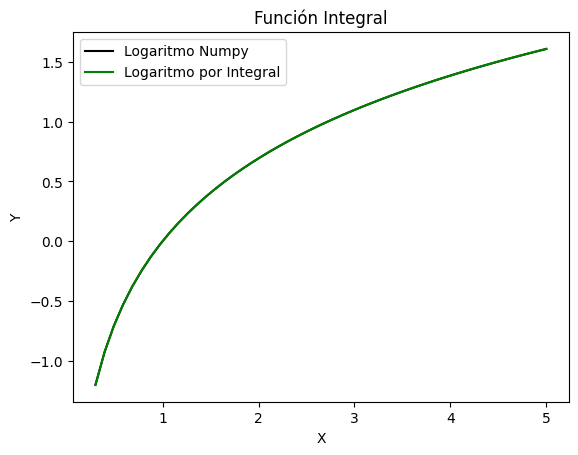

In [25]:
# Gráfica de funciones

plt.plot(Dom,Y1, c='k', label="Logaritmo Numpy")
plt.plot(Dom,Y2, c='g', label="Logaritmo por Integral")

plt.xlabel("X")
plt.ylabel("Y")
plt.title("Función Integral")


plt.legend()

plt.show()

# Obtención de funciones integrales por medio de datos

Utilizando todo lo anterior, dado un conjunto de datos 

$$
\{(x_i, y_i) : 1 \leq i \leq n \}
$$

es posible obtener un polinomio que aproxime a la función de la que provienen los puntos, y más aún, es posible obtener la función integral asociada a la misma por medio de la integración numérica.

La importancia de esto radica en el hecho de que en ciertas ocasiones, las mediciones obtenidas de un experimento, corresponden a la derivada de la función de interés teóricamente, por lo que la obtención de la función integral, nos permite obtener los valores de la función de interés.

Como ejemplo sencillo, se puede pensar en el movimiento de una partícula en el espacio. Al realizar cierto experimento, solamente es posible calcular la aceleración de la partícula en el espacio, sin embargo, se desea conocer su posición. 

Así, a partir del conjunto de datos de la forma

$$
\mathbf{a}_i = (a_{x,i}, a_{y,i}, a_{z,i})
$$

es posible aproximar un polinomio para cada coordenada. Teniendo que 

$$
\mathbf{a}(t) = (a_x(t), a_y(t), a_z(t))
$$

Y utilizando el hecho de que

$$
a_i(t) = \frac{d v_i(t)}{dt}
$$

Podemos obtener la velocidad de la partícula

$$
\mathbf{v} = \left( \int a_x(t) dt, \int a_y(t) dt, \int a_z(t) dt \right) 
= (v_x(t),v_y(t),v_z(t))
$$

e integrando una segunda vez, es posible obtener nuestras funciones de interés

$$
\mathbf{r} = \left( \int v_x(t) dt, \int v_y(t) dt, \int v_z(t) dt \right)
= (r_x(t),r_y(t),r_z(t))
$$

## Ejemplo con los datos de metales pesados

Utilizando los datos para metales pesados, seleccionaremos los datos correspondiendes a pacientes con diagnóstico normal y se selccionará un metal en específico.

Por medio de un histograma, se generará un conjunto de puntos que aproximarán a la densidad de probabilidad de la concentración del metal en una persona con diagnóstico sano.

Al conjunto de datos obtenidos se les aproximará un polinomio, que por hipótesis, aproximará a la función de densidad de probabilidad. 

Y obtenida la aproximación, es posible encontrar la distribución de probabilidad integrando la función de densidad. Esta función se obtendrá mediante la integración numérica. 

La densidad de probabilidad permitirá establecer un rango de concentración en el cuál se encuentra la mayor parte de las personas con Dx normal.

In [26]:
# Importación de los datos
with open('metalesNorm.csv',newline='') as f:
    reader=csv.reader(f)
    data_str=list(reader)

# Vector de datos string numpy array
data_str=np.array(data_str)

# Dimensiones de los datos
(m,n) = data_str.shape
(m,n)

(41, 16)

In [27]:
# Volver los datos float
data=np.zeros((m,n))
for i in range(m):
    for j in range(n):
        data[i][j] = float(data_str[i][j])

In [28]:
# Vector de strings para los metales
MetStr = ["Pb", "Mn", "Cd", "As", "Mg", "Al", "V", "Cr",
          "Co", "Ni", "Cu", "Zn", "Se", "Sb", "Cs", "Ba",
         ]
MetStr = np.array(MetStr)

Utilizaremos el Mg como ejemplo, sin embargo, esto puede realizarse en cualquier metal. El índice correspondiente el Mg es el 4. Así, únicamente nos quedaremos con la columna 4 de nuestra matriz de datos

In [29]:
MetStr[4]

'Mg'

In [30]:
Mg = data[:,4]

In [31]:
# Obtención del histograma
Y,X = np.histogram(Mg, bins=10)
Y,X

(array([3, 4, 7, 9, 7, 5, 2, 1, 2, 1]),
 array([2848.59360552, 3134.33720166, 3420.0807978 , 3705.82439394,
        3991.56799008, 4277.31158622, 4563.05518236, 4848.7987785 ,
        5134.54237465, 5420.28597079, 5706.02956693]))

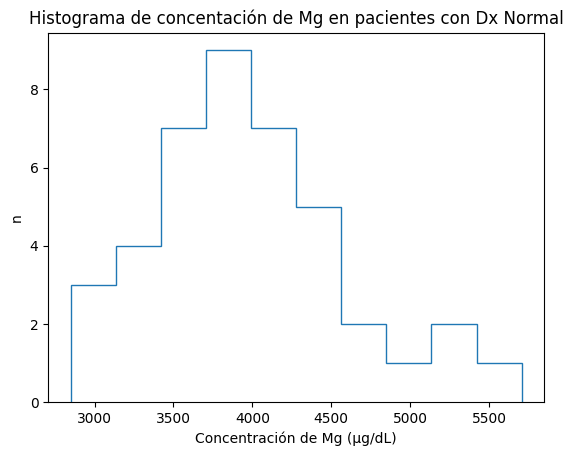

In [32]:
# Visualización del histograma

plt.stairs(Y,X)

plt.xlabel("Concentración de Mg (μg/dL)")
plt.ylabel("n")
plt.title("Histograma de concentación de Mg en pacientes con Dx Normal")

plt.show()

Para obtener los puntos que podrían aproximar a la densidad de probabiliad, en lugar de tener tener la cantidad de personas en cada región, se obtendrán puntos, los cuáles tendrán como coordenada $x$ al punto medio de cada intervalo y como coordenada $y$ el valor de la frecuencia asociada a dicho intervalo.

Algo importante a tomar en cuenta, es que para que el histograma pueda aproximar a la densidad de probabilidad, la integral sobre toda la región de concentraciones debe ser uno. El ajuste se hará después de la obtención del polinomio aproximado para tener libertad en la selección del máximo valor de concentración dado.

In [33]:
# Creación de puntos
X1 = np.zeros(10)

for i in range(10):
    X1[i] = (X[i]+X[i+1])/2

X = X1

In [34]:
# Matriz de datos
PuntDensProb = np.vstack((X,Y))
PuntDensProb = PuntDensProb.T

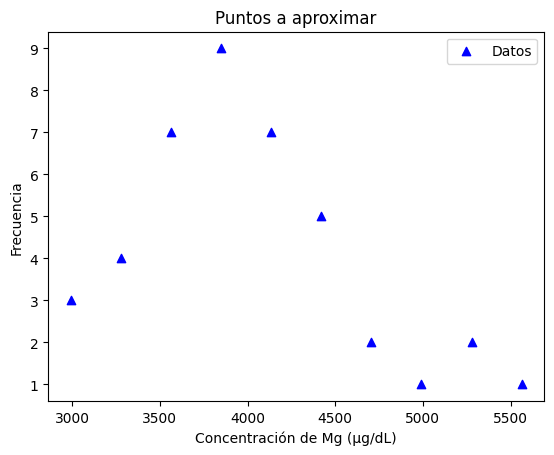

In [35]:
# Gráfica de los puntos a aproximar

plt.scatter(PuntDensProb[:,0],PuntDensProb[:,1], c='b', marker = '^', label="Datos")

plt.xlabel("Concentración de Mg (μg/dL)")
plt.ylabel("Frecuencia")
plt.title("Puntos a aproximar")

plt.legend()

plt.show()

In [36]:
grad = 3

def P(x):
    return AjusPoli(PuntDensProb,grad,x)

In [37]:
xmin = min(PuntDensProb[:,0])
xmax = max(PuntDensProb[:,0])

In [38]:
NumPuntGraf = 50
Dom = np.linspace(xmin-70,xmax-200,NumPuntGraf)
Y1 = P(Dom)

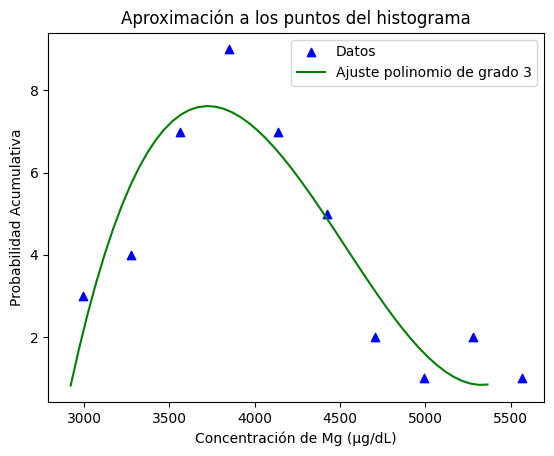

In [39]:
# Gráfica de la aproximación

plt.scatter(X,Y, c='b', marker = '^', label="Datos")
plt.plot(Dom,Y1, c='g', label=("Ajuste polinomio de grado " +str(grad)) )

plt.xlabel("Concentración de Mg (μg/dL)")
plt.ylabel("Probabilidad Acumulativa")
plt.title("Aproximación a los puntos del histograma")


plt.legend()

plt.show()

Se obtendrá ahora la integral en el inervalo $[xmin - 70, xmax -200]$. Se ajustará la función para que el total de la integral sea uno y esté bien definida nuestra densidad de probabilidad.

In [40]:
xmin -= 70
xmax -= 200
IntP = IntSimpComp(P,xmin,xmax)
xmin

2921.4654035873327

Definimos ahora densidad de Probabilidad de la concentración de Mg.

In [41]:
def DensProb(x):
    return P(x)/IntP

Comprobamos que la integral en el intervalo descrito sea uno

In [42]:
IntSimpComp(DensProb, xmin, xmax)

0.9999999999999999

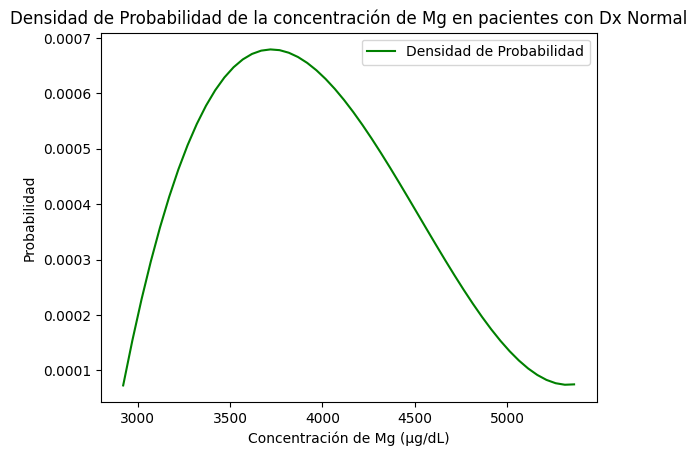

In [43]:
# Gráfica de la densidad de probabilidad

NumPuntGraf = 50
Dom = np.linspace(xmin,xmax,NumPuntGraf)
Y1 = DensProb(Dom)

plt.plot(Dom,Y1, c='g', label="Densidad de Probabilidad" )

plt.xlabel("Concentración de Mg (μg/dL)")
plt.ylabel("Probabilidad")
plt.title("Densidad de Probabilidad de la concentración de Mg en pacientes con Dx Normal")


plt.legend()

plt.show()

A partir de la densidad, es posible obtener la media de la concentración buscando un $x_0$ tal que dada $\phi(x)$ densidad de probabilidad, se cumpla que

$$
\int_{xmin}^{x_0} \phi(t) dt = 0.5
$$

Aunque esto es posible obtenerlo a prueba y error, resulta más sencillo obtener la función de distribución de probabilidad o probabilidad acumlativa, dada por

$$
F(x) = \int_{xmin}^{x} \phi(t) dt
$$

Así, utilizaremos nuestra integral numérica para definir esta función integral.

In [44]:
def DistProb(x):
    return IntSimpComp(DensProb,xmin,x,10**3)

Graficaremos nuestra función para encontrar el valor para el cuál nuestra función da como resultado $1/2$.

In [45]:
# Puntos para la gráfica
NumPuntGraf = 15

Dom = np.linspace(xmin-100,xmax+100,NumPuntGraf)

Y2 = np.zeros(NumPuntGraf)
for i in range(NumPuntGraf):
    Y2[i] = DistProb(Dom[i])

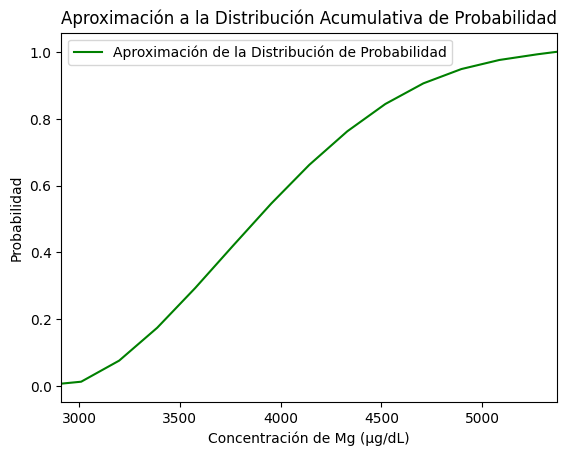

In [46]:
# Gráfica de la distribución de Probabilidad

plt.plot(Dom,Y2, c='g', label="Aproximación de la Distribución de Probabilidad" )

plt.xlabel("Concentración de Mg (μg/dL)")
plt.ylabel("Probabilidad")
plt.title("Aproximación a la Distribución Acumulativa de Probabilidad")
plt.xlim(xmin-10,xmax+10)


plt.legend()

plt.show()

Podemos observar que la media se encuentra cerca del valor 4000. Se probará con valores cercanos a este valor.

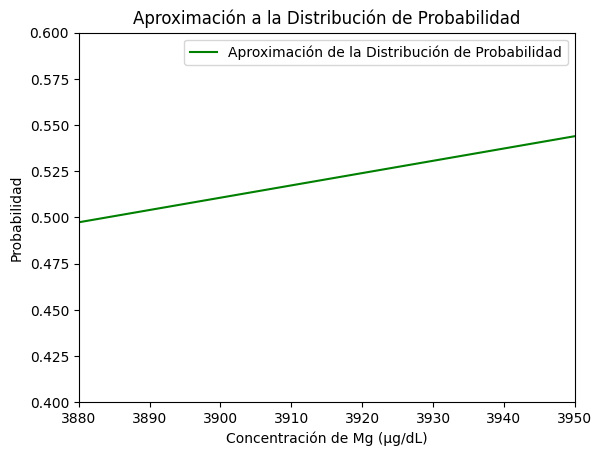

In [47]:
# Gráfica de la distribución de Probabilidad

plt.plot(Dom,Y2, c='g', label="Aproximación de la Distribución de Probabilidad" )

plt.xlabel("Concentración de Mg (μg/dL)")
plt.ylabel("Probabilidad")
plt.title("Aproximación a la Distribución de Probabilidad")

plt.xlim(3880, 3950)
plt.ylim(0.4,0.6)


plt.legend()

plt.show()

In [48]:
μ = 3882.8054427725909
IntSimpComp(DensProb, xmin, μ)

0.5000000000000057

La media es $\mu = 3882.8054427725909$. 

Utilizando esto, se obtendrá un intervalo alrededor de la media en el que se encuentren la mayor parte de las personas con Dx normal. Diremos que la mayor parte corresponde al menos al 95% de probabilidad.

In [49]:
# Definición de la vecindad
ε = 955
limInf = μ - ε
limSup = μ + ε

# Condición de intervalo
if (limInf>xmin and limSup<xmax):
    # Cálculo de la probabilidad en la vecindad
    print(IntSimpComp(DensProb,limInf, limSup))
else:
    print("La vecindad está fuera de los límites")

0.9371020628593374


Por lo que la concentración de Magnesio $\rho_{\text{Mg}}$ para personas con Dx Normal, oscila mayormente en el rango

$$
\rho_{\text{Mg}} = 3882.8054427725909 \pm 955 [\mu \text{g} / \text{d L}]
$$

In [50]:
# Importación de los datos
with open('perf1.csv',newline='') as f:
    reader=csv.reader(f)
    data_str=list(reader)

# Vector de datos string numpy array
data_str=np.array(data_str)

# Dimensiones de los datos
(m,n) = data_str.shape
(m,n)

(35, 25)

In [51]:
# Volver los datos float
perf=np.zeros((m,n))
for i in range(m):
    for j in range(n):
        perf[i][j] = float(data_str[i][j])

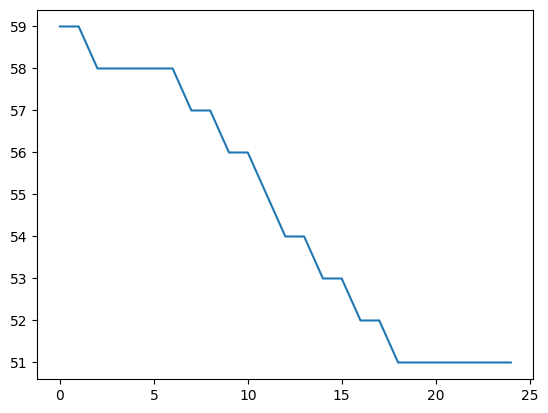

In [52]:
plt.plot(perf[0])

In [53]:
data_perf = np.zeros((25,2))
for i in range(25):
    data_perf[i][0]=i
    data_perf[i][1]=perf[0][i]

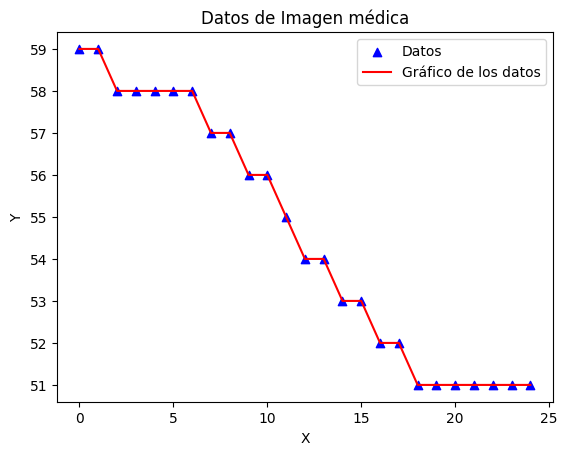

In [54]:
plt.scatter(data_perf[:,0],data_perf[:,1], c='b', marker='^', label="Datos")
plt.plot(data_perf[:,1], c='r', label="Gráfico de los datos")

plt.xlabel("X")
plt.ylabel("Y")
plt.title("Datos de Imagen médica")


plt.legend()

plt.show()

In [55]:
def perf_pol(x):
    return AjusPoli(data_perf,3,x)

In [56]:
Dom = np.linspace(0,25,100)

Y = perf_pol(Dom)

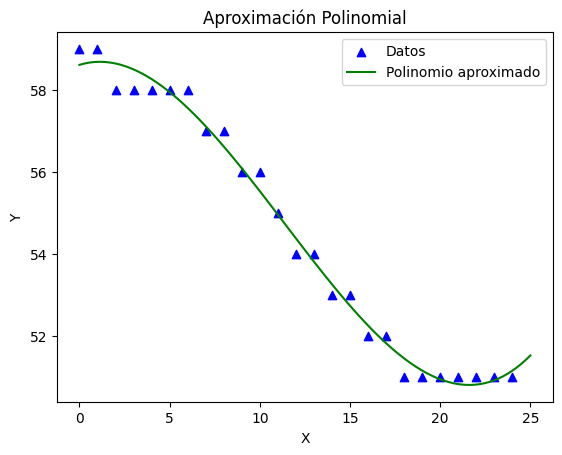

In [57]:
plt.scatter(data_perf[:,0],data_perf[:,1], c='b', marker='^', label="Datos")
plt.plot(Dom,Y, c='g', label="Polinomio aproximado")

plt.xlabel("X")
plt.ylabel("Y")
plt.title("Aproximación Polinomial")


plt.legend()

plt.show()